In [1]:
%cd ..
%ls 

from ch_est_net.preloading import *
from ch_est_net.utils import *


from torch.fft import fft, ifft, fftshift, ifftshift
from ch_est_net import activation

%load_ext autoreload
%autoreload 2

import torch
print(torch.__version__)

import wandb
USE_WANDB = False

/home/alex/GitHub/ML_for_channel_estimation
ch_est_net/        lista_beam_net.pt  output.svg        torchvix-sample
config_beams.yaml  model_image        __pycache__/      torchvix-sample.png
config.yaml        model_image.png    README.md         wandb/
data.h5            Notebooks/         requirements.txt  zero_150.pt
DMRS_signal/       one.pt             results/          zero.pt
1.10.1


In [2]:
cfg, dataL, dataS, device, deviceType, dtype, file, ml_default, onePilotFolder, path ,preload, print_function, scen0, Scenario = crazy_preloader()

Using CPU

Preload data: OK


In [132]:
def get_batch(snr_range, ind_range, seed):
    '''
    For files ind_range add noise with snr_range and stack all realizations to single array
    --------------------------------------------------------------------------
    RETURNS:
    pilot_batch -> [Realizations ; Antennas ; Subc ; Re/Im ]
    data_batch  -> [Realizations ; Antennas ; Subc ; 12? ; Re/Im]
    pilot_batch -> [Realizations]
    --------------------------------------------------------------------------
    Realizations = len(snr_range)*len(ind_range) 
    '''

    pilot_batch = torch.tensor(())
    pilot_noisy_batch = torch.tensor(())
    data_batch = torch.tensor(())
    noise_P_batch = torch.tensor(())

    for snr in snr_range:
        for ind in ind_range:
            h_pilot, h_data = data_load(scen0, dtype = dtype, onePilotFolder = onePilotFolder,dataL=dataL, ind = ind) 
                                                  # load data
            h_pilot_noisy, _ = add_noise(h_pilot, SNR = snr,scen=scen0, dtype=dtype, seed = seed)                             # add noise to pilots
            h_data_noisy, data_noise_power = add_noise_data(h_data, SNR = snr, dtype = dtype, seed = seed)     # add noise to data

            h_pilot = h_pilot.mean(dim = 2).unsqueeze(dim = 0)                                  # mean over pilots dim and add aditional dim
            h_pilot_noisy = h_pilot_noisy.mean(dim = 2).unsqueeze(dim = 0)

            h_data_noisy = h_data_noisy.unsqueeze(dim = 0)                                      # add additional dim for
            data_noise_power = data_noise_power.unsqueeze(dim =0)

            pilot_batch = torch.cat((pilot_batch, h_pilot), dim = 0)

            pilot_noisy_batch = torch.cat((pilot_noisy_batch, h_pilot_noisy), dim = 0)
            data_batch = torch.cat((data_batch, h_data_noisy), dim = 0)
            noise_P_batch = torch.cat((noise_P_batch, data_noise_power), dim = 0)

    return pilot_batch, pilot_noisy_batch, data_batch, noise_P_batch


# x_batch, u_batch, _, _ = get_batch(snr_range = [-12, -8, -6 , -3 ,0],
#                                             ind_range = range(1, 140, 3),
#                                             seed = 3)

x_batch, u_batch, _, _ = get_batch(snr_range = [ -20, -15, -17,],
                                            ind_range = range(1, 141, 2),
                                            seed = 3)



x_test, u_test, _, _ = get_batch(snr_range = [-10, -9, -5 , -2 , -1],
                                              ind_range = range(2, 141, 2),
                                              seed = 2)

x_batch = x_batch[:,:,:,0] + 1j*x_batch[:,:,:,1]
u_batch = u_batch[:,:,:,0] + 1j*u_batch[:,:,:,1]

x_test = x_test[:,:,:,0] + 1j*x_test[:,:,:,1]
u_test = u_test[:,:,:,0] + 1j*u_test[:,:,:,1]


In [6]:
x.shape

torch.Size([64, 48])

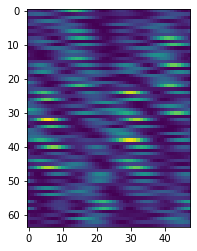

In [133]:
x = x_batch[1,:]

plt.imshow(abs(x)**2)
x_t  = torch.roll(ifft(x_batch, n = 500, dim = 2, norm = 'ortho'),200, dims =2 )
x_t_b = fft(x_t,n=500,dim = 1, norm = 'ortho')

u_t  = torch.roll(ifft(u_batch, n = 500, dim = 2, norm = 'ortho'),200, dims =2 )
u_t_b = fft(u_t,n=500,dim = 1, norm = 'ortho')


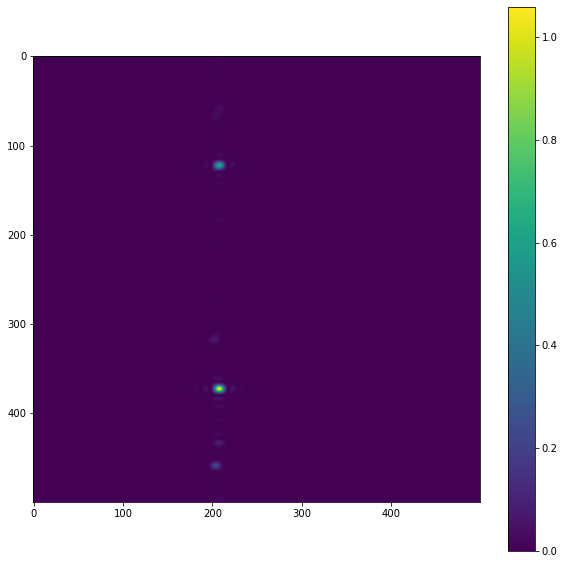

In [134]:
plt.figure(figsize= (10,10))
plt.imshow(abs(x_t_b[4,:,:])**2)
plt.colorbar()

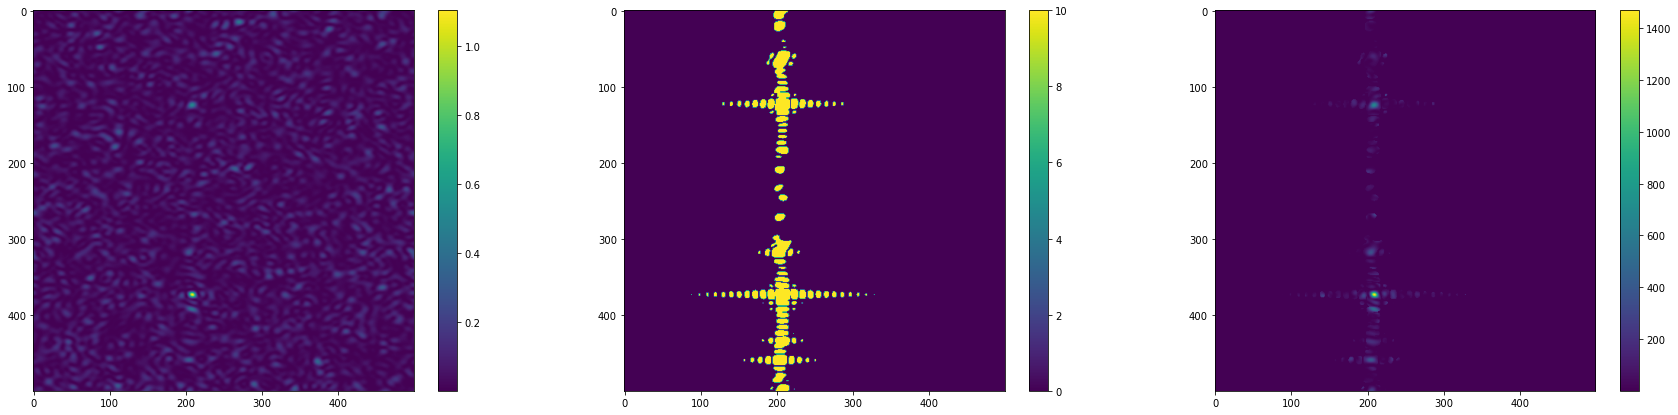

In [160]:
plt.figure(figsize= (30,7))

signal = abs(x_t_b[4,:,:])**2
#signal = signal/torch.max(signal)


noisy = abs(u_t_b[4,:,:])**2
#noisy = noisy/torch.max(noisy)

cut = torch.nn.functional.threshold(signal, 0.001, 0)
cut = cut / torch.max(cut)
cut[cut!=0] = 10


plt.subplot(1,3,1)
plt.imshow(noisy)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(cut)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(noisy*(cut+1)**3)
plt.colorbar()


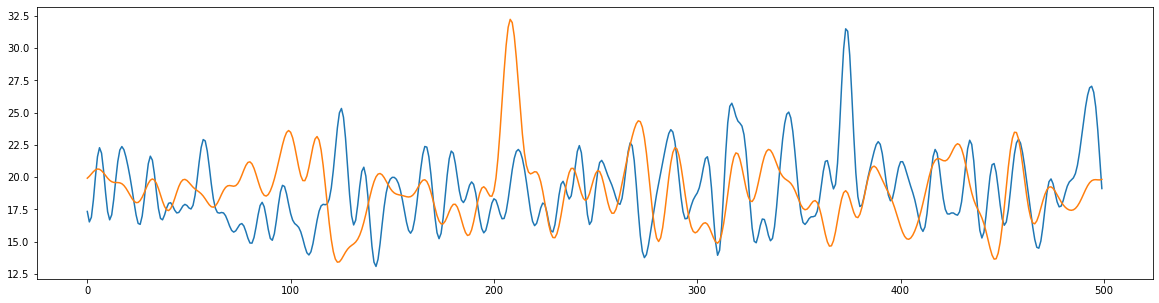

In [149]:
plt.figure(figsize=(20,5))
plt.plot(torch.sum(noisy,1))
plt.plot(torch.sum(noisy,0))